![](img/arima.jpeg)

El mundo de la previsión de series temporales mediante modelos ARIMA (media móvil integrada autorregresiva) y SARIMAX (media móvil integrada autorregresiva estacional con regresores eXógenos) en Python, el panorama actual, impulsado por los datos, la capacidad de predecir con exactitud las tendencias futuras tiene un valor incalculable. Ya se trate de predecir los movimientos del mercado de valores, los patrones meteorológicos o la planificación de las ventas de productos, comprender y utilizar estas potentes herramientas estadísticas puede proporcionarle una ventaja significativa.

Este notebook le guiará a través de los modelos ARIMA y SARIMAX, dos de las metodologías más utilizadas en el análisis de series temporales. Exploraremos sus fundamentos teóricos, sus implementaciones prácticas en Python y sus aplicaciones en escenarios reales.

## Entendiendo ARIMA y SARIMAX
Antes de sumergirnos en las implementaciones de Python, aclaremos qué son los modelos ARIMA y SARIMAX y en qué se diferencian.

- **Modelo ARIMA**:

    El modelo ARIMA es una mezcla de tres componentes:

    1. **Autorregresivo (AR)**: Esta parte capta la relación entre el valor actual de una variable y sus valores anteriores.
    2. **Integrada (I)**: Implica diferenciar los datos una o más veces para hacer estacionaria la serie temporal.
    3. **Media móvil (MA)**: Este componente modela el término de error como una combinación lineal de términos de error en puntos temporales anteriores.

    El modelo ARIMA se denomina ARIMA(p, d, q), donde:

    - *p* es el número de observaciones retardadas en el modelo AR.
    - *d* es el grado de diferenciación.
    - *q* es el tamaño de la ventana de la media móvil.

- Modelo SARIMAX

    SARIMAX amplía ARIMA añadiendo dos aspectos clave:

    1. **Estacionalidad**: Tiene en cuenta las variaciones estacionales utilizando los elementos estacionales P, D, Q y m.
    2. **Regresores exógenos**: Son variables externas que pueden influir en la variable pronosticada.
    
    En SARIMAX(P, D, Q, m), los parámetros representan:

    - *P, D, Q*: Componentes estacionales equivalentes a p, d, q en ARIMA.
    - *m*: Número de periodos de cada estación.
    
    Cuando P, D, Q y m son cero y no se incluyen variables exógenas, SARIMAX se simplifica a un modelo ARIMA.

## Librerías Python para ARIMA y SARIMAX

1. **Statsmodels**:

    Es una biblioteca completa para la modelización estadística. Es particularmente fácil de usar para aquellos con experiencia en R.

2. **pmdarima**:

    Adapta el modelo SARIMAX de statsmodels a la API de scikit-learn, por lo que es una gran opción para los usuarios familiarizados con scikit-learn.

3. **skforecast**:

    Adapta el modelo statsmodels SARIMAX y está diseñado para ofrecer velocidad y simplicidad, alineándose con la API de scikit-learn.


### ForecasterSarimax

La clase ForecasterSarimax permite entrenar y validar modelos ARIMA y SARIMAX utilizando la API de skforecast. ForecasterSarimax es compatible con la implementación Sarimax de skforecast, un novedoso envoltorio para los modelos estadísticos SARIMAX que también sigue la API de sklearn. Esta implementación es muy similar a pmdarima, pero se ha racionalizado para incluir sólo los elementos esenciales para skforecast, lo que se traduce en importantes mejoras de velocidad.


In [1]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn-v0_8-darkgrid')

# statsmodels
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # skforecast
from skforecast.datasets import fetch_dataset
from skforecast.model_selection import TimeSeriesFold

# from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax, grid_search_sarimax
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")



## **1. Datos**
El conjunto de datos de este documento es un resumen del consumo mensual de combustible en España.

In [6]:
import pandas as pd
import requests
from io import StringIO

url = "https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/consumos-combustibles-mensual.csv"

response = requests.get(url, verify=False)  # Desactiva la verificación SSL
if response.status_code == 200:
    datos = pd.read_csv(StringIO(response.text))
    print(datos.head())
else:
    print("Error al descargar los datos")


        Fecha          GLPs    Gasolinas   Querosenos     Gasoleos  \
0  1969-01-01  133615.09620  166875.2129  123257.8090  401185.2939   
1  1969-02-01  126748.47410  155466.8105  114682.5767  385360.0381   
2  1969-03-01  107795.80910  184983.6699  109970.0796  418955.5808   
3  1969-04-01   96683.15967  202319.8164  108797.9255  438975.5445   
4  1969-05-01   79506.23804  206259.1523  103554.0784  467451.9469   

     Fueloleos  
0  912583.4202  
1  851877.8115  
2  873884.2933  
3  755490.1170  
4  729963.6009  


/Users/isaromobru/Desktop/DS102024_/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
# Descarga datos
#datos = pd.read_csv('https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/consumos-combustibles-mensual.csv')
datos = fetch_dataset(name='fuel_consumption', raw=True,version='latest')
datos = datos[['Fecha', 'Gasolinas']]
datos = datos.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m-%d')
datos = datos.set_index('date')
datos = datos.loc[:'1990-01-01 00:00:00']
datos = datos.asfreq('MS')
datos = datos['litters']
display(datos.head())

ValueError: Error reading dataset 'fuel_consumption' from https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/consumos-combustibles-mensual.csv. Try to version = 'latest'

In [7]:
# Fechas Train-test

fin_train = '1980-01-01 23:59:59'
print(
    f"Fechas train : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas test  : {datos.loc[fin_train:].index.min()} --- {datos.loc[:].index.max()}  "
    f"(n={len(datos.loc[fin_train:])})"
)
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

Fechas train : 0 --- 198  (n=199)
Fechas test  : 199 --- 643  (n=445)


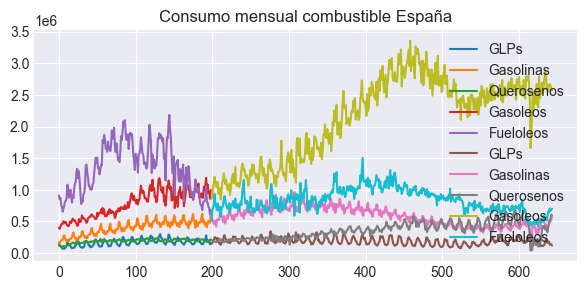

In [8]:
# Gráfico
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend();

## **2. Análisis Exploratorio**

Crear un modelo ARIMA requiere un análisis exploratorio exhaustivo. Este paso crítico sirve de brújula, guiando al analista hacia una comprensión detallada de la dinámica intrínseca de los datos. Antes de entrenar un modelo ARIMA a una serie temporal, es importante realizar un análisis exploratorio para determinar, como mínimo, lo siguiente:

1. Estacionariedad: Significa que las propiedades estadísticas (media, varianza...) permanecen constantes a lo largo del tiempo, por lo que las series temporales con tendencias o estacionalidad no son estacionarias. Dado que ARIMA presupone la estacionariedad de los datos, es esencial someterlos a pruebas rigurosas, como la prueba Dickey-Fuller aumentada, para evaluar que se cumple. Si se constata la no estacionariedad, las series deben diferenciarse hasta alcanzar la estacionariedad. Este análisis ayuda a determinar el valor óptimo del parámetro  d.

2. Análisis de autocorrelación: Graficar las funciones de autocorrelación y autocorrelación parcial (ACF y PACF) para identificar posibles relaciones de rezago (lags) entre los valores de la serie. Este análisis visual ayuda a determinar los términos autorregresivos (AR) y de media móvil (MA) adecuados ( p y q ) para el modelo ARIMA.

3. Descomposición estacional: en los casos donde se sospecha de estacionalidad, descomponer la serie en componentes de tendencia, estacionales y residuales utilizando técnicas como las medias móviles la descomposición estacional de series temporales (STL) puede revelar patrones ocultos y ayudar a identificar la estacionalidad. Este análisis ayuda a determinar los valores óptimos de los parámetros  P, D, Q y m.

Estos análisis exploratorios establecen la base para empezar a construir un modelo ARIMA efectivo que capture los patrones fundamentales y las asociaciones dentro de los datos.

### **3. Estacionariedad**

Existen varios métodos para evaluar si una serie temporal es estacionaria o no estacionaria:

1. Inspección visual de la serie temporal: inspeccionando visualmente el gráfico de la serie temporal, es posible identificar la presencia de una tendencia o estacionalidad notables. Si se observan estos patrones, es probable que la serie no sea estacionaria.

2. Valores estadísticos: calcular estadísticos como la media y la varianza, de varios segmentos de la serie. Si existen diferencias significativas, la serie no es estacionaria.

3. Pruebas estadísticas: utilizar test estadísticos como la prueba Dickey-Fuller aumentada o la prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS).

El gráfico generado en el apartado anterior muestra una clara tendencia positiva, lo que indica un aumento constante a lo largo del tiempo. En consecuencia, la media de la serie aumenta con el tiempo, lo que confirma su no estacionariedad.

La diferenciación es una de las técnicas más sencillas para eliminar la tendencia de una serie temporal. Consiste en generar una nueva serie en la que cada valor se calcula como la diferencia entre el valor actual y el valor anterior, es decir, la diferencia entre valores consecutivos. Matemáticamente, la primera diferencia se calcula como:

$$ΔXt=Xt−Xt−1$$

Donde  $X_t$ es el valor en el tiempo $t$ y $X_t−1$ es el valor en el tiempo $t−1$. Esta es conocida como diferenciación de primer orden. Este proceso se puede repetir si es necesario hasta que se alcance la estacionariedad deseada.



#### Prueba de Dickey-Fuller aumentada

La prueba Dickey-Fuller aumentada considera como hipótesis nula que la serie temporal tiene una raíz unitaria, una característica frecuente de las series temporales no estacionarias. Por el contrario, la hipótesis alternativa (bajo la cual se rechaza la hipótesis nula) es que la serie es estacionaria.

+ Hipótesis nula ( $H_O$ ): La serie tiene una raíz unitaria, no es estacionaria.

+ Hipótesis alternativa ( $H_A$ ): La serie no tiene raíz unitaria, es estacionaria.

Dado que la hipótesis nula supone la presencia de una raíz unitaria, el p-value obtenido debe ser inferior a un nivel de significación determinado, a menudo fijado en 0.05, para rechazar esta hipótesis. Este resultado indica la estacionariedad de la serie. La función ``adfuller()`` de la biblioteca Statsmodels permite aplicar la prueba ADF. Su resultado incluye cuatro valores: el p-value, el valor del estadístico, el número de retardos (lags) incluidos en la prueba y los umbrales del valor crítico para tres niveles diferentes de significancia.

#### Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS).

La prueba KPSS se utiliza para verificar si hay tendencia en la serie temporal. En otras palabras, evalúa si los datos muestran una tendencia en el tiempo que podría hacer que la serie sea no estacionaria.

 -Hipótesis nula (H0): La serie temporal es estacionaria alrededor de una tendencia determinista (es decir, que la serie no tiene tendencia).   
 -Hipótesis alternativa (H1): La serie tiene una tendencia significativa, lo que significa que no es estacionaria.

¿Qué pasa con el p-value?

Si el p-value es bajo (generalmente por debajo de 0.05), entonces rechazamos la hipótesis nula (H0) y concluimos que la serie tiene una tendencia no estacionaria.
Si el p-value es alto, no tenemos suficiente evidencia para rechazar la hipótesis nula y concluimos que la serie es estacionaria o no muestra una tendencia fuerte.

**NOTA**:
Si bien ambas pruebas se utilizan para comprobar la estacionariedad:

- La prueba KPSS se centra en la presencia de tendencias. Un p-value bajo indica la no estacionariedad debida a una tendencia.

- La prueba ADF se centra en la presencia de una raíz unitaria. Un p-value bajo indica que la serie temporal no tiene una raíz unitaria, lo que sugiere que podría ser estacionaria.

Es habitual utilizar ambas pruebas a la vez para comprender mejor las propiedades de estacionariedad de una serie temporal.

In [9]:
# Test estacionariedad

warnings.filterwarnings("ignore")

datos_diff_1 = datos_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

TypeError: unsupported operand type(s) for -: 'str' and 'str'

### **4. Análisis de autocorrelación**

El gráfico de la función de autocorrelación ( Autocorrelation Function ACF) y la función de autocorrelación parcial (Partial Autocorrelation Function (PACF)) de la serie temporal proporciona información útil sobre los posibles valores adecuados de *p* y *q*. La ACF ayuda a identificar el valor de *q* (retardos en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de *p* (retardos en la parte autorregresiva).

#### Función de autocorrelación (ACF)

La ACF calcula la correlación entre una serie temporal y sus valores retardados (lags). En el contexto de la modelización ARIMA, una caída brusca de la ACF después de unos pocos retardos indica que los datos tienen un orden autorregresivo finito. El retardo en el que cae la ACF proporciona una estimación del valor de *q*. Si el ACF muestra un patrón sinusoidal o sinusoidal amortiguado, sugiere la presencia de estacionalidad y requiere la consideración de órdenes estacionales además de órdenes no estacionales.


In [ ]:
# Grafico de autocorrelación para la serie original y la serie diferenciada

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');


#### Función de autocorrelación parcial (PACF)

La PACF mide la correlación entre un valor retardado (lag) y el valor actual de la serie temporal, teniendo en cuenta el efecto de los retardos intermedios. En el contexto de la modelización ARIMA, si la PACF se corta bruscamente después de un determinado retardo, mientras que los valores restantes están dentro del intervalo de confianza, sugiere un modelo AR de ese orden. El desfase en el que se corta el PACF da una idea del valor de *p*.

In [ ]:
# Autocorrelación parcial para la serie original y la serie diferenciada
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

**NOTA**:

Algunas reglas generales son:

- Utilizar un orden del término AR p igual al numero de *lags* que cruzan el límite de significancia en el gráfico PACF.

- Utilizar un orden del término MA q igual al numero de *lags* que cruzan el límite de significancia en el gráfico ACF.

- Si el ACF corta en el lag q y el PACF corta en el lag p, se recomienda empezar con un modelo ARIMA(p, d, q).

- Si sólo el PACF decae después del lag p, se recomienda empezar con un modelo AR(p).

- Si sólo el ACF decae después del lag q, se recomienda empezar con un modelo MA(q).

Estas pautas proporcionan un punto de partida útil al seleccionar los órdenes de un modelo ARIMA y pueden ser ajustadas según las características específicas de los datos en cuestión.

Acorde a la función de autocorrelación, el valor óptimo para el parámetro *p* es 0. Sin embargo, se va a asignar un valor de 1 para proporcionar un componente autorregresivo al modelo. En cuanto al componente *q*, la función de autocorrelación parcial sugiere un valor de 1.

### **5. Descomposición de series temporales**

La descomposición de series temporales consiste en descomponer la serie temporal original en sus componentes fundamentales: la tendencia, la estacionalidad y los residuos. Esta descomposición puede llevarse a cabo de manera aditiva o multiplicativa. Al combinar la descomposición de las series temporales con el análisis de la ACF y la PACF, se obtiene una descripción bastante completa con la que comprender la estructura subyacente de los datos y acotar el valor los parámetros ARIMA más apropiados.

In [ ]:
# Descomposición de la serie original y la serie diferenciada

res_decompose = seasonal_decompose(datos, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0])
axs[0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1])
axs[1].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2])
axs[2].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3])
axs[3].set_title('Residuos', fontsize=12)
datos_diff_1.plot(ax=axs[4])
axs[4].set_title('Serie_differenciada', fontsize=12)

fig.suptitle('Descomposición de la serie original ', fontsize=14)
fig.tight_layout();

- El patrón recurrente cada 12 meses sugiere una estacionalidad anual, probablemente influenciada por factores vacacionales. 
- El gráfico de ACF respalda aún más la presencia de esta estacionalidad, ya que se observan picos significativos en los lags correspondientes a los intervalos de 12 meses, confirmando la idea de patrones recurrentes.

### **6. Conclusiones**

Basandose en los resultados del análisis exploratorio, utilizar una combinación de diferenciación de primer orden y diferenciación estacional puede ser el enfoque más apropiado. La diferenciación de primer orden es efectiva para capturar las transiciones entre observaciones y resaltar las fluctuaciones a corto plazo. Al mismo tiempo, la diferenciación estacional, que abarca un período de 12 meses y representa el cambio de un año a otro, captura de manera efectiva los patrones cíclicos inherentes en los datos. Este enfoque nos permite lograr la estacionariedad necesaria para el proceso de modelado ARIMA subsiguiente.

###  **8. ForecasterSarimax**

La clase ForecasterSarimax permite entrenar y validar modelos ARIMA y SARIMAX utilizando la API de skforecast. 

Sarimax from skforecast: una nueva envoltura de statsmodels SARIMAX que también sigue la API de sklearn. Esta implementación es muy similar a pmdarima, pero ha sido optimizada para incluir solo los elementos esenciales para skforecast, lo que resulta en mejoras significativas de velocidad.

Dado que ForecasterSarimax sigue la misma API que los otros Forecasters disponibles en la librería, es muy fácil hacer una comparación robusta del rendimiento de modelos ARIMA-SARIMAX frente a otros modelos de machine learning como Random Forest or Gradient Boosting.

#### **8.1 Entrenamiento - Predicción**

El proceso de entrenamiento y predicción sigue una API similar a la de scikit-learn.

In [ ]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax

forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 0), seasonal_order=(0, 1, 0, 12))
             )
forecaster.fit(y=datos_train, suppress_warnings=True)

# Predicción
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head()

#### **8.2 Backtesting**

El siguiente ejemplo muestra el uso de backtesting para evaluar el rendimiento del modelo SARIMAX al generar predicciones para los 12 meses siguientes en un plan anual. En este contexto, se genera una previsión al final de cada mes de diciembre, prediciendo valores para los 12 meses siguientes.

In [ ]:
# Instanciamos de objeto forecasterSarimax
''' A diferencia del cross-validation estándar, que puede mezclar datos de diferentes épocas, el cross-validation en 
series temporales respeta el orden temporal de los datos'''

forecaster = ForecasterSarimax(
                 regressor=Sarimax( #
                                order=(0, 1, 0),# Estos son los hiperparámetros del modelo (p, d, q) 
                                seasonal_order=(0, 1, 0, 12),# Estos son los hiperparámetros del modelo (P, D, Q, S)
                                maxiter=200 # Número máximo de iteraciones que el optimizador de SARIMAX puede realizar para ajustar el modelo.
                            )
             )

#Definimos el esquema de validación cruzada con TimeSeriesFold

cv = TimeSeriesFold(
        steps              = 12,# Porque los datos son mensuales
        initial_train_size = len(datos_train),# Tamaño inicial de los datos de entrenamiento
        refit              = True,#Esto indica que, al final de cada iteración del backtesting, el modelo se reentrenará con los datos más recientes.
        fixed_train_size   = False,# Este parámetro indica que el tamaño del conjunto de entrenamiento no es fijo, sino que crece con cada iteración.
)

metrica, predicciones_sarimax_f = backtesting_sarimax(
                            forecaster            = forecaster,# Es el modelo que se usará para hacer las predicciones.
                            y                     = datos,
                            cv=cv,
                            metric                = 'mean_absolute_error',
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,# Esto suprime las advertencias durante el proceso de ajuste del modelo
                            verbose               = True,# Esto permite que se muestren detalles adicionales del proceso de backtesting mientras se ejecuta
                            show_progress         = True #Muestra una barra de progreso mientras se ejecuta el proceso de backtesting
)
print(f'Metrica: {metrica}' )
print(f' predicciones: \n {predicciones_sarimax_f.head()}')

In [ ]:
rmse= root_mean_squared_error(datos_test, predicciones_sarimax_f)
rmse

In [ ]:
# Gráfico predicciones de backtesting
fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_train:].plot(ax=ax, label='test')
predicciones_sarimax_f.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend();

#### **8.3 Optimización de Hiperparámetros**

Cuando estamos ajustando un modelo, especialmente modelos como **ARIMA** o **SARIMAX**, tenemos varios parámetros que deben ser elegidos para que el modelo funcione correctamente. Estos parámetros se conocen como **hiperparámetros** y son **p**, **d** y **q** en el caso de ARIMA:

- **p**: Orden de los términos autoregresivos (AR).
- **d**: Número de diferenciaciones (para hacerlo estacionario).
- **q**: Orden de los términos de la media móvil (MA).

Pero, ¿cómo encontramos los mejores valores para estos hiperparámetros? **Dos enfoques comunes** pueden ayudarnos a encontrar los valores ideales: **criterios estadísticos** y **técnicas de validación**.



##### a. Criterios Estadísticos

Este enfoque se basa en el uso de **métricas estadísticas** como el **AIC (Criterio de Información de Akaike)** o el **BIC (Criterio de Información Bayesiano)**. Estas métricas miden cuán bien se ajusta el modelo a los datos, pero con un toque importante: **penalizan la complejidad** del modelo.

- **¿Cómo funciona?**
  - El modelo calcula la **verosimilitud** (qué tan probable es que los datos sean generados por el modelo) y luego **penaliza** los modelos más complejos.
  - Cuanto más pequeño sea el **AIC** o el **BIC**, mejor es el modelo (en términos relativos).
  
- **Ventaja**: 
  - **Rápido y eficiente**, ya que no se necesita hacer predicciones sobre nuevos datos. Solo se usa el conjunto de entrenamiento para evaluar el modelo.
  
- **Pero ojo**: Solo nos dice si un modelo es **mejor que otro**. No garantiza que el modelo sea perfecto, por lo que aún necesitamos **validarlo**.


##### a. Técnicas de Validación (Más Lento, Pero Más Preciso)

Aquí, entran en juego las **técnicas de validación**, como el **backtesting**, que simula cómo se comportaría el modelo en el "mundo real". ¿Por qué es útil?

- **¿Cómo funciona?**
  - Usamos **datos históricos** para evaluar cómo el modelo predice valores futuros.
  - Durante el backtesting, se **ajusta el modelo** a los datos de entrenamiento y luego se **evalúa su rendimiento** en datos que no se vieron durante el entrenamiento.

- **Ventaja**: 
  - Este enfoque ofrece una evaluación **más robusta** y más cercana a la realidad, ya que mide cómo de bien generaliza el modelo a datos desconocidos.

- **Desventaja**: 
  - **Más lento**: El modelo debe ser **reentrenado** y evaluado múltiples veces, lo que lleva más tiempo.


#### **8.4 División de datos**

In [ ]:
# Train-validation-test

fin_train = '1976-01-01 23:59:59'
fin_val = '1984-01-01 23:59:59'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)

In [ ]:
# Gráfico

fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:fin_val].plot(ax=ax, label='validación')
datos.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend();

La combinación de criterios estadísticos con backtesting permite optimizar los hiperparámetros rápidamente y luego validar su rendimiento real. Aunque los criterios AIC/BIC son rápidos y te ayudan a encontrar una buena configuración inicial, el backtesting te permite validar si ese conjunto de parámetros realmente funciona bien en un escenario de predicción en datos futuros.

#### **8.5 Grid Search**

Grid Search te ayuda a explorar diferentes combinaciones de parámetros de manera estructurada, pero siempre teniendo en cuenta la validación real con backtesting, que es más robusta y realista que sólo calcular AIC/BIC en los datos de entrenamiento.

In [ ]:
# Grid search basado en backtesting
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Marcador de posición inicial sustituido en gridsearch
                                maxiter=500
                            )
             )

# param_grid = {
#     'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
#     'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
#     'trend': [None, 'n', 'c'] #(sin tendencia, tendencia lineal o constante).
# }
from itertools import product

# Definir los rangos de valores para p, d, q, P, D, Q, y m
p_range = range(2)  # Ejemplo: 0, 1, 2
d_range = range(1,2) # Ejemplo: 0, 1
q_range = range(2)  # Ejemplo: 0, 1, 2
P_range = range(2)  # Ejemplo: 0, 1
D_range = range(2)  # Ejemplo: 0, 1
Q_range = range(2)  # Ejemplo: 0, 1
m_values = range(12,13)  # Periodo estacional (por ejemplo, mensual)

# Generar todas las combinaciones posibles para order y seasonal_order
param_grid = {
    'order': [(p, d, q) for p, d, q in product(p_range, d_range, q_range)],
    'seasonal_order': [(P, D, Q, m) for P, D, Q, m in product(P_range, D_range, Q_range, m_values)]
}

cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(datos_train),
        refit              = True,
        fixed_train_size   = False,
    )


resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = datos.loc[:fin_val],
                        param_grid            = param_grid,
                        cv                    = cv,
                        metric                = 'mean_absolute_error',
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )
resultados_grid.head()

Evaluando el modelo seleccionado por grid_search_sarimax basado en backtesting


In [ ]:
# Predicciones de backtesting con el mejor modelo según el grid search

forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
                 
             )

cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size    = len(datos.loc[:fin_val]),
        refit              = True,
        fixed_train_size   = False,
    )
metrica_m1, predicciones_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                cv=cv,
                                metric                = 'mean_absolute_error',
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

In [ ]:
# Comparación de métricas

print("Metrica (mean absolute error) del modelo grid search:",metrica_m1)

fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_val:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m1.plot(ax=ax)
ax.legend();

La configuración SARIMAX identificada mediante la técnica de grid search (basada en backtesting con error medio absoluto) ofrece resultados ligeramente mejores.

#### **8.6 Exogenous variables**

Dentro de la biblioteca statsmodels, la implementación de ARIMA-SARIMAX ofrece una valiosa característica: la posibilidad de integrar variables exógenas como factores de previsión junto a la serie temporal primaria considerada. El único requisito para incluir una variable exógena es la necesidad de conocer el valor de la variable también durante el periodo de previsión. La adición de variables exógenas se realiza utilizando el argumento exog.




### **9. Predicciones con un Modelo ARIMA-SARIMAX ya entrenado**

Cuando trabajamos con un modelo ARIMA (y también con SARIMAX, que es una extensión de ARIMA para manejar estacionalidad y otras variables exógenas), uno de los principales retos es cómo hacer predicciones cuando los datos futuros no siguen inmediatamente después de la última observación utilizada en el entrenamiento.

En un modelo ARIMA, existe un componente clave llamado **media móvil (MA)**. Este componente utiliza los **errores de las predicciones anteriores** para realizar nuevas predicciones. Por ejemplo, para predecir el valor en el **tiempo t**, el modelo necesita saber cuál fue el **error de la predicción en t-1**. Sin embargo, si no tenemos esa predicción (porque estamos tratando de predecir en el futuro), el modelo no tiene el **error de la predicción** necesario para continuar con sus cálculos. Esto hace que, en la mayoría de los casos, sea necesario **volver a entrenar** el modelo cada vez que queremos hacer una predicción.

**¿Por qué no es ideal volver a entrenar el modelo cada vez?**
1. **Tiempo:** El proceso de entrenamiento puede ser **lento** y consumir muchos recursos, especialmente si estamos trabajando con grandes volúmenes de datos.
2. **Recursos computacionales:** Volver a entrenar el modelo cada vez puede ser **ineficiente** si no tenemos acceso rápido o suficiente capacidad de procesamiento.

### **La Solución: Alimentar al Modelo con Datos Recientes**

Una solución práctica es alimentar al modelo con solo los **datos más recientes** desde el momento en que se entrenó hasta el momento de la predicción. Por ejemplo, imagina que entrenamos un modelo hace 20 días usando datos diarios de los últimos tres años. Cuando queramos hacer nuevas predicciones, solo necesitaremos **los últimos 20 días de datos**, en lugar de todos los datos históricos (que serían 365 * 3 + 20 valores). 

Esto **reduce el tiempo y los recursos necesarios**, pero sigue permitiendo que el modelo sea capaz de realizar predicciones precisas basadas en los últimos errores y comportamientos observados.

### **Automatización con la Clase ForecasterSarimax**

El proceso de integrar estos nuevos datos al modelo y hacer predicciones puede ser un poco complejo, pero la clase `ForecasterSarimax` hace todo este trabajo automáticamente. A través de su parámetro **`last_window`** en el método **`predict`**, el modelo puede tomar los datos más recientes, hacer las predicciones necesarias y ajustarse de manera eficiente sin tener que volver a entrenarse completamente.

Esto significa que no tienes que preocuparte por reentrenar el modelo cada vez que quieras hacer una predicción; solo alimentas los datos más recientes y el modelo se ajusta automáticamente para hacer las predicciones.

In [ ]:
# División de los datos en entrenamiento y last window

# Establecemos la fecha límite para los datos de entrenamiento
fin_train = '1980-01-01 23:59:59'
                       
# Los datos de entrenamiento son aquellos hasta la fecha de fin_train
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)

# Los datos de la last window son aquellos posteriores a fin_train hasta la última fecha disponible
print(
    f"Fechas Last window  : {datos.loc[fin_train:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_train:])})"
)

In [ ]:
# Gráfico de los datos de entrenamiento y last window
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:].plot(ax=ax, label='last window')
ax.set_title('Consumo mensual combustible España')
ax.legend();

El Forecaster se entrena utilizando datos hasta el '1980-01-01' y luego utilizará la información restante como última ventana de observaciones para generar nuevas predicciones.

In [ ]:
# El modelo se entrena con los datos hasta la fecha fin_train y los hiperparámetros d
# el modelo son los mismos que en el ejemplo anterior
forecaster = ForecasterSarimax(
                regressor = Sarimax(
                    order          = (0, 1, 1),         # ARIMA(0,1,1): parte no estacional del modelo
                    seasonal_order = (1, 1, 1, 12),     # SARIMA(1,1,1,12): componente estacional (12 períodos)
                    maxiter        = 500                 # Máximo número de iteraciones para optimizar el modelo
                )
)
# El modelo se ajusta (entrena) utilizando los datos hasta la fecha fin_train
forecaster.fit(y=datos.loc[:fin_train])


Se realiza la predicción utilizando la "last window" de datos. El modelo hace las predicciones para los siguientes 12 períodos de tiempo, usando solo los datos de la "last window" (los más recientes disponibles).

In [ ]:
# La last window contiene los datos desde fin_train hasta la última observación

predicciones = forecaster.predict(
                  steps       = 12,
                  last_window = datos.loc[fin_train:]
              )
predicciones.head()

In [ ]:
# Gráfico predicciones

fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:].plot(ax=ax, label='last window')
predicciones.plot(ax=ax, label='predicciones')
ax.set_title('Consumo mensual combustible España')
ax.legend();